In [ ]:
!pip install -q sklearn

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
def Plotter(acc,val_acc,loss,val_loss,l_r):
  
  plt.plot(acc, label='accuracy')
  plt.plot(val_acc, label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()


  plt.plot(loss, label='loss')
  plt.plot(val_loss, label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend(loc='lower right')
  plt.show()

  plt.plot(l_r, label='Learning Rate')
  # plt.plot(val_loss, label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('LR')
  plt.legend(loc='lower right')
  plt.show()

In [ ]:
import pathlib

dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

In [ ]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [ ]:
# In the original dataset "4" indicates the pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop un-used columns.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

In [ ]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')
# train

7383 train examples
1846 validation examples
2308 test examples


In [ ]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([ 6  2 20  4  2], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([1 1 0 1 1], shape=(5,), dtype=int64)


In [ ]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [ ]:
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 1.1036534 ],
       [ 0.46038508],
       [-1.1477859 ],
       [ 0.13875087],
       [-0.18288334]], dtype=float32)>

In [ ]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [ ]:
type_col = train_features['Type']
layer = get_category_encoding_layer('Type', train_ds, 'string')
layer(type_col)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)>

In [ ]:
type_col = train_features['Age']
category_encoding_layer = get_category_encoding_layer('Age', train_ds,
                                                      'int64', 5)
category_encoding_layer(type_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)>

In [ ]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [ ]:
# Categorical features encoded as integers.
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')
encoding_layer = get_category_encoding_layer('Age', train_ds, dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [ ]:
# Categorical features encoded as string.
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


In [ ]:
def mymodel():
  all_features = tf.keras.layers.concatenate(encoded_features)
  x = tf.keras.layers.Dense(32, activation="relu")(all_features)
  x = tf.keras.layers.Dropout(0.5)(x)
  output = tf.keras.layers.Dense(1)(x)
  model = tf.keras.Model(all_inputs, output)
  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["accuracy"])
  return model

model = mymodel()

In [ ]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


Default manner

In [ ]:

history = model.fit(train_ds, epochs=150, validation_data=val_ds)

Epoch 1/150
29/29 [==============================] - 0s 7ms/step - loss: 0.4993 - accuracy: 0.7460 - val_loss: 0.4876 - val_accuracy: 0.7421
Epoch 2/150
29/29 [==============================] - 0s 8ms/step - loss: 0.5017 - accuracy: 0.7458 - val_loss: 0.4881 - val_accuracy: 0.7438
Epoch 3/150
29/29 [==============================] - 0s 7ms/step - loss: 0.5003 - accuracy: 0.7470 - val_loss: 0.4876 - val_accuracy: 0.7454
Epoch 4/150
29/29 [==============================] - 0s 7ms/step - loss: 0.4945 - accuracy: 0.7543 - val_loss: 0.4877 - val_accuracy: 0.7405
Epoch 5/150
29/29 [==============================] - 0s 7ms/step - loss: 0.4974 - accuracy: 0.7559 - val_loss: 0.4871 - val_accuracy: 0.7438
Epoch 6/150
29/29 [==============================] - 0s 7ms/step - loss: 0.5018 - accuracy: 0.7482 - val_loss: 0.4881 - val_accuracy: 0.7432
Epoch 7/150
29/29 [==============================] - 0s 6ms/step - loss: 0.4988 - accuracy: 0.7504 - val_loss: 0.4878 - val_accuracy: 0.7438
Epoch 8/150
2

In [ ]:
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']

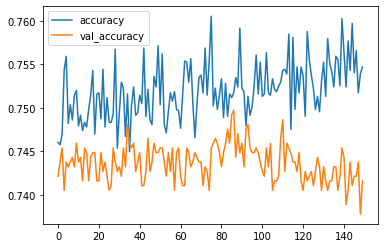

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

Test LR

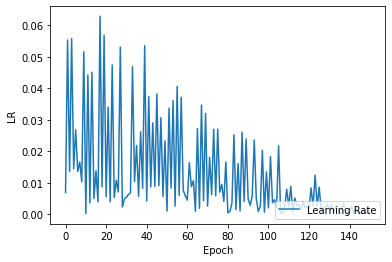

In [ ]:
from random import random,randint,randrange,uniform
lr = []
epoo=151
for z,batch_size in zip(range(1,epoo+1),range(5,10000,5)):

  # print(z,(batch_size)/((z+1)**(3/2))/80)
  


  if (z%2 == 0):
    LR = random() * batch_size/10000
    lr.append(LR)
  else:
    LR = random() * z/10000
    lr.append(LR)

lr = lr[::-1] 
lord_LR = lr
# print(min(lr))


plt.plot(lr, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.legend(loc='lower right')
plt.show()

Our Method

In [ ]:
from keras.callbacks import LearningRateScheduler
model = mymodel()
LR = 0.01
epoch = 1
batch_size = 100

val_acc = []
acc = []
val_loss = []
loss = []
l_r = []

num = 0
x = 0
for z,batch_size in zip(range(1,150+1),range(5,10000,5)):

  if (z%2 == 0):
    LR = random() * batch_size/10000
  # lr.append(LR)
  else:
    LR = random() * z/10000
  # lr.append(LR)

  print("\n\nepoch {z}, Learning Rate {LR}, Batch Size  {batch_size} "
                    .format(z=z,LR=LR,batch_size=batch_size))

  def set_LR(epoch,lr):
    global LR
    global l_r
    global x
    global lord_LR 

    LR=lord_LR[x]
    x+=1
    if(LR>0.009):
      LR = 0.009
    l_r.append(LR)
    return LR

  call = [ LearningRateScheduler(set_LR,verbose=1) ]


  # history = model.fit(
  #           datagen.flow(x_train, y_train, 
  #           batch_size=batch_size),
  #           validation_data=(x_test,y_test),
  #           epochs=epoch,
  #           callbacks=call
  #           )
  
  history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    batch_size = batch_size, 
    epochs=1,
    callbacks=call,
  )



  acc.append(history.history['accuracy'])
  val_acc.append(history.history['val_accuracy'])
  loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])



epoch 1, Learning Rate 7.601791025297018e-05, Batch Size  5 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.006847011551927991.
29/29 [==============================] - 2s 23ms/step - loss: 0.5807 - accuracy: 0.6562 - val_loss: 0.5125 - val_accuracy: 0.7302


epoch 2, Learning Rate 0.0007116473244507295, Batch Size  10 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009.
29/29 [==============================] - 0s 6ms/step - loss: 0.5385 - accuracy: 0.7088 - val_loss: 0.4968 - val_accuracy: 0.7459


epoch 3, Learning Rate 4.3127670059210945e-05, Batch Size  15 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009.
29/29 [==============================] - 0s 7ms/step - loss: 0.5294 - accuracy: 0.7152 - val_loss: 0.4945 - val_accuracy: 0.7346


epoch 4, Learning Rate 0.001175998915413486, Batch Size  20 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009.
29/29 [==============================] - 0s 7ms/step - loss: 0.526

In [ ]:
acc_2 = acc
val_acc_2 = val_acc

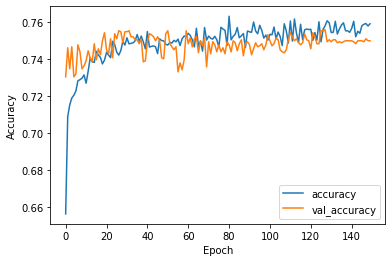

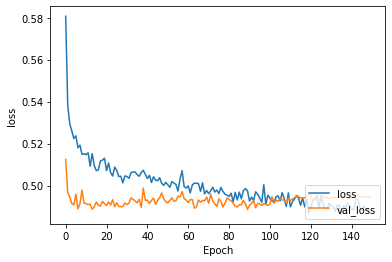

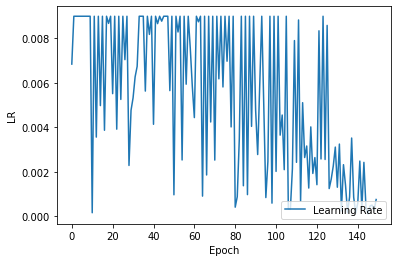

In [ ]:
Plotter(acc,val_acc,loss,val_loss,l_r)

BS = const

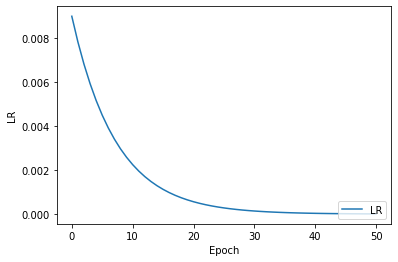

In [ ]:
initial_learning_rate = 0.009
decay_steps=5
decay_rate=0.5
LR = []
for i in range(51):
  lr = initial_learning_rate * decay_rate **(i / decay_steps)
  LR.append(lr)
plt.plot(LR, label='LR')
# plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model = mymodel()

from keras.callbacks import LearningRateScheduler

LR = 0.01
epoch = 1
batch_size = 100

val_acc = []
acc = []
val_loss = []
loss = []
l_r = []
initial_learning_rate = 0.009
decay_steps=5
decay_rate=0.5
LR = []
def setLR(step):
  global LR
  lr = initial_learning_rate * decay_rate **(step / decay_steps)
  LR.append(lr)
  # print("called here")
  return lr

call = [ LearningRateScheduler(setLR,verbose=1) ]
history = model.fit(
  train_ds, 
  validation_data=val_ds, 
  # batch_size = batch_size, 
  epochs=150,
  callbacks=call,
)



acc.append(history.history['accuracy'])
val_acc.append(history.history['val_accuracy'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

Epoch 1/150

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009.
29/29 [==============================] - 2s 22ms/step - loss: 0.5875 - accuracy: 0.6604 - val_loss: 0.5052 - val_accuracy: 0.7421
Epoch 2/150

Epoch 00002: LearningRateScheduler reducing learning rate to 0.007834955069665117.
29/29 [==============================] - 0s 5ms/step - loss: 0.5372 - accuracy: 0.7119 - val_loss: 0.4960 - val_accuracy: 0.7346
Epoch 3/150

Epoch 00003: LearningRateScheduler reducing learning rate to 0.006820724549296791.
29/29 [==============================] - 0s 7ms/step - loss: 0.5295 - accuracy: 0.7172 - val_loss: 0.4938 - val_accuracy: 0.7421
Epoch 4/150

Epoch 00004: LearningRateScheduler reducing learning rate to 0.005937785598478023.
29/29 [==============================] - 0s 6ms/step - loss: 0.5235 - accuracy: 0.7236 - val_loss: 0.4922 - val_accuracy: 0.7378
Epoch 5/150

Epoch 00005: LearningRateScheduler reducing learning rate to 0.005169142597486656.
29/29 [===========

In [ ]:
acc_3 = acc[0]
val_acc_3 = val_acc[0]

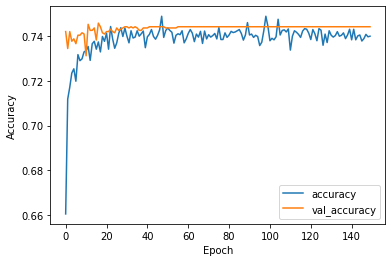

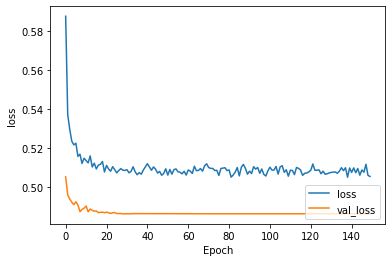

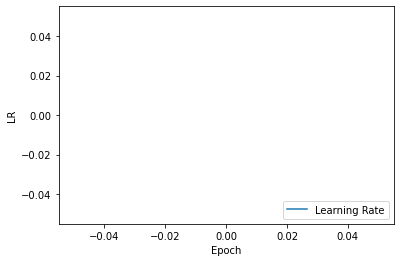

In [ ]:
Plotter(acc[0],val_acc[0],loss[0],val_loss[0],l_r)

LR const

In [ ]:
model = mymodel()

from keras.callbacks import LearningRateScheduler

LR = 0.01
epoch = 1
batch_size = 100

val_acc = []
acc = []
val_loss = []
loss = []
l_r = []
for z,batch_size in zip(range(1,150+1),range(5,10000,5)):

  LR = (batch_size)/(((z+1)**(3/2))*80)
  LR=LR/8

  print("\n\nepoch {z}, Learning Rate {LR}, Batch Size  {batch_size} "
                    .format(z=z,LR=LR,batch_size=batch_size))

  def set_LR(epoch,lr):
    global LR
    global l_r
    l_r.append(LR)
    return LR

  call = [ LearningRateScheduler(set_LR,verbose=1) ]

  # history = model.fit(
  #           datagen.flow(x_train, y_train, 
  #           batch_size=batch_size),
  #           validation_data=(x_test,y_test),
  #           epochs=epoch,
  #           # callbacks=call
  #           )
  
  history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    batch_size = batch_size, 
    epochs=1,
    # callbacks=call,
  )



  acc.append(history.history['accuracy'])
  val_acc.append(history.history['val_accuracy'])
  loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])



epoch 1, Learning Rate 0.002762135864009951, Batch Size  5 
29/29 [==============================] - 2s 22ms/step - loss: 0.7125 - accuracy: 0.4552 - val_loss: 0.6066 - val_accuracy: 0.6273


epoch 2, Learning Rate 0.003007032652029301, Batch Size  10 
29/29 [==============================] - 0s 7ms/step - loss: 0.6363 - accuracy: 0.5989 - val_loss: 0.5685 - val_accuracy: 0.7037


epoch 3, Learning Rate 0.0029296875, Batch Size  15 
29/29 [==============================] - 0s 7ms/step - loss: 0.5989 - accuracy: 0.6426 - val_loss: 0.5462 - val_accuracy: 0.7124


epoch 4, Learning Rate 0.002795084971874737, Batch Size  20 
29/29 [==============================] - 0s 6ms/step - loss: 0.5771 - accuracy: 0.6696 - val_loss: 0.5312 - val_accuracy: 0.7308


epoch 5, Learning Rate 0.0026578664743741078, Batch Size  25 
29/29 [==============================] - 0s 6ms/step - loss: 0.5654 - accuracy: 0.6824 - val_loss: 0.5218 - val_accuracy: 0.7356


epoch 6, Learning Rate 0.0025310120960439324,

In [ ]:
acc_4 = acc
val_acc_4 = val_acc

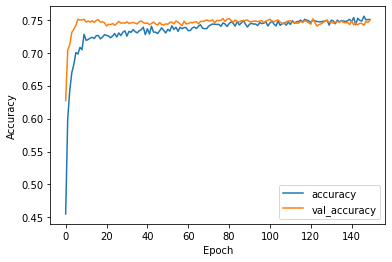

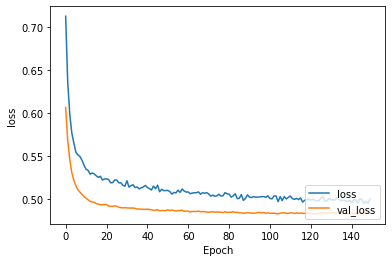

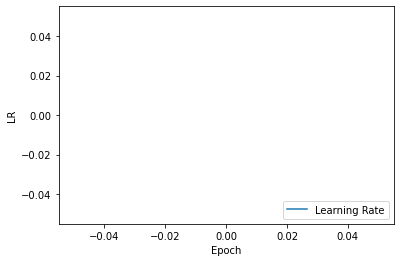

In [ ]:
Plotter(acc,val_acc,loss,val_loss,l_r)

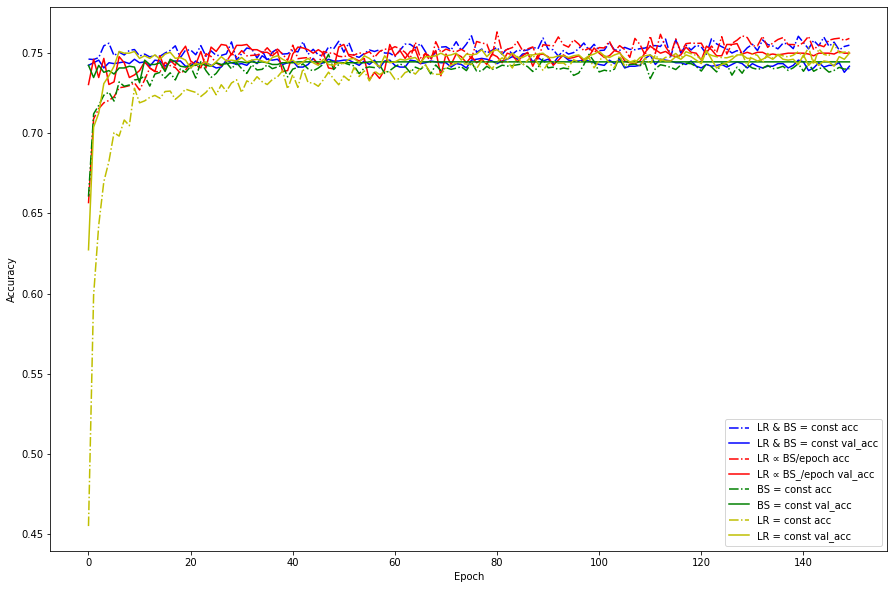

In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(acc_1, label='LR & BS = const acc',ls='-.',c='b')
plt.plot(val_acc_1, label = 'LR & BS = const val_acc',c='b')
plt.plot(acc_2, label='LR ∝ BS/epoch acc',ls='-.',c='r')
plt.plot(val_acc_2, label = 'LR ∝ BS_/epoch val_acc',c='r')
plt.plot(acc_3, label='BS = const acc',ls='-.',c='g')
plt.plot(val_acc_3, label = 'BS = const val_acc',c='g')
plt.plot(acc_4, label='LR = const acc',ls='-.',c='y')
plt.plot(val_acc_4, label = 'LR = const val_acc',c='y')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


# case4_fashion_acc,case4_fashion_val_acc0

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

10/10 [==============================] - 0s 4ms/step - loss: 0.5166 - accuracy: 0.7383
Accuracy 0.7383015751838684


In [ ]:
model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')

INFO:tensorflow:Assets written to: my_pet_classifier/assets


INFO:tensorflow:Assets written to: my_pet_classifier/assets


In [ ]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

This particular pet had a 82.0 percent probability of getting adopted.
